# A Project On CO2 Emmison Forecasting

#### Importing the required libraries

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

####  Reading the data and manipulation on the data

In [107]:
df=pd.read_csv("co2_mm_mlo.csv")
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


In [108]:
#making a column of date so that we can use it as the index
df['date']=pd.to_datetime({'year':df['year'],'month':df['month'],'day':1})
df=df.set_index('date')
df.index.freq='MS'
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


In [109]:
#making a new dataframe of useful columns
df1=pd.DataFrame(df['interpolated'])

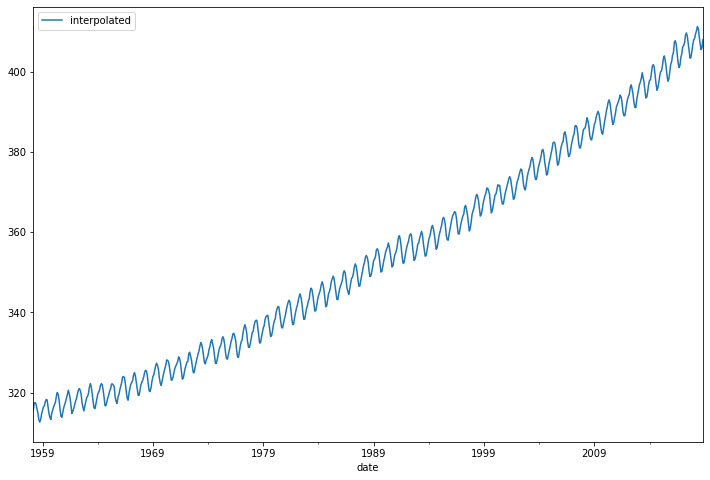

In [61]:
df1.plot(figsize=(12,8))

#### Doing ELT decomposition  to check the the seasonality

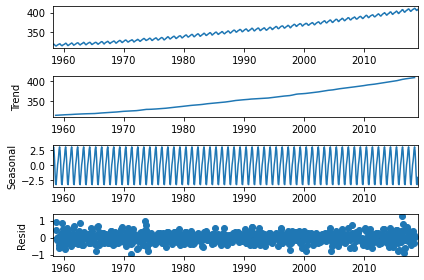

In [110]:
seasonal_decompose(df1).plot();

#### Using Automation method to best choose the order of our Seasonal Arima Model

In [65]:
auto_arima(df1,start_p=0,start_q=0,max_d=3,max_p=3,seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -206.252
Date:                            Sun, 15 Nov 2020   AIC                            424.504
Time:                                    16:27:30   BIC                            452.046
Sample:                                         0   HQIC                           435.131
                                            - 729                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3517      0.107      3.294      0.001       0.142       0.561
ar.L2          0.0873      0.050      1.745      0.081      -0.011       0.185
ma.L1         -0.7074      0.098     -7.204      0.000      -0.900      -0.515
ar.S.L12       0.9996      0.000   3019.369      0.000       0.999       1.000
ma.S.L12      -0.8663      0.021    -40.548      0.000      -0.908      -0.824
sigma2         0.0956      0.005     20.480      0.000       0.086       0.105
===================================================================================
Ljung-Box (Q):                       43.66   Jarque-Bera (JB):                 4.50
Prob(Q):                              0.32   Prob(JB):                         0.11
Heteroskedasticity (H):               1.13   Skew:                            -0.00
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [111]:
#simple order and seasonal order of our model
order=(2, 1, 1)
se_order=(1, 0, 1, 12)

#### Spliting the model into train and test split

In [68]:
train=df1.iloc[:717]
test=df1.iloc[717:]

#### Fitting the model into the training set

In [116]:
model=SARIMAX(train,order=order,seasonal_order=se_order).fit()

In [117]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(2, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -201.886
Date:                            Sun, 15 Nov 2020   AIC                            415.771
Time:                                    17:17:27   BIC                            443.214
Sample:                                03-01-1958   HQIC                           426.368
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3477      0.068      5.130      0.000       0.215       0.481
ar.L2          0.0855      0.029      2.923      0.003       0.028       0.143
ma.L1         -0.7010      0.062    -11.290      0.000      -0.823      -0.579
ar.S.L12       0.9996      0.000   2818.459      0.000       0.999       1.000
ma.S.L12      -0.8666      0.023    -38.037      0.000      -0.911      -0.822
sigma2         0.0954      0.005     20.267      0.000       0.086       0.105
===================================================================================
Ljung-Box (Q):                       44.44   Jarque-Bera (JB):                 4.64
Prob(Q):                              0.29   Prob(JB):                         0.10
Heteroskedasticity (H):               1.14   Skew:                             0.01
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Predicting the test data by the model which we have fitted into our training data

In [114]:
test_prediction=model.predict(start=len(train),end=len(train)+len(test)-1,typ='levels').rename('predicted')

#### Plotting the test and predicted data

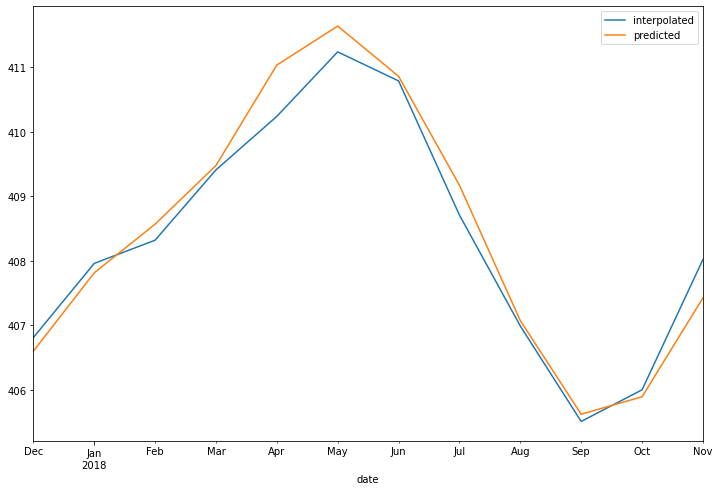

In [115]:
test.plot(figsize=(12,8))
test_prediction.plot(legend=True)

Look like a good fitting 

#### Evaluating the model

In [118]:
from sklearn.metrics import mean_squared_error

In [119]:

np.sqrt(mean_squared_error(test,test_prediction))

0.3570258990638173

#### Now fitting the model into the whole dataset to forecast the future outcomes

In [102]:
final_model=SARIMAX(df1,order=order,seasonal_order=se_order).fit()

In [105]:
prediction=final_model.predict(start=len(df1),end=len(df1)+12,typ='levels').rename('Prediction')

#### Plotting of forecasting data of 1 year

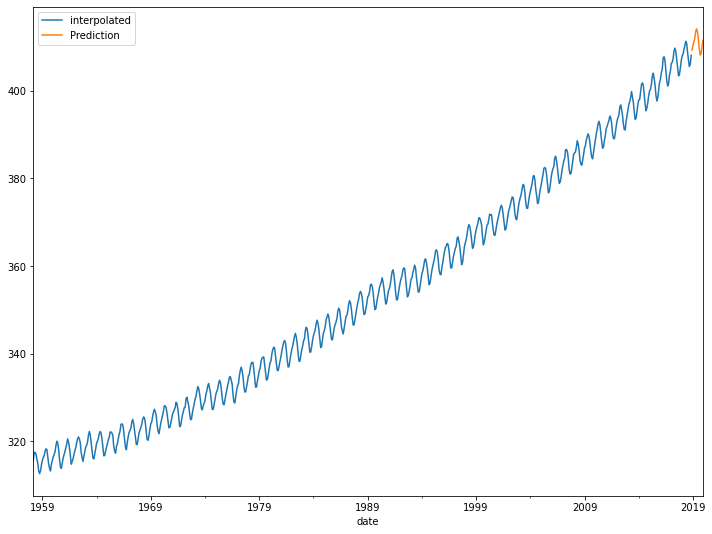

In [120]:
df1.plot(figsize=(12,9))
prediction.plot(legend=True)